# Demo 3

> Test Fast.ai models with a simple supervised learning test


In [1]:
# | default_exp demo.demo3

In [2]:
!gpustat

merlin                      Thu Nov 23 13:23:20 2023  525.125.06
[0] NVIDIA GeForce RTX 4090 | 42°C,   0 % |     6 / 24564 MB |
[1] NVIDIA GeForce RTX 4090 | 41°C,  19 % |   649 / 24564 MB |


In [3]:
#| hide
from nbdev.showdoc import *

%matplotlib inline
from fastai.vision.all import *
from fastai.data.all import *
import torch.nn.functional as F

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

from Noise2Model.core import *

from IPython.display import clear_output, DisplayHandle
def update_patch(self, obj):
    clear_output(wait=True)
    self.display(obj)
DisplayHandle.update = update_patch

In [4]:
bs, size = 4, 512
# arch = models.resnet34
path = Path('../_data/Confocal_BPAE_B/')
path_train_raw = Path(path/"raw")
path_train_gt = Path(path/"gt")

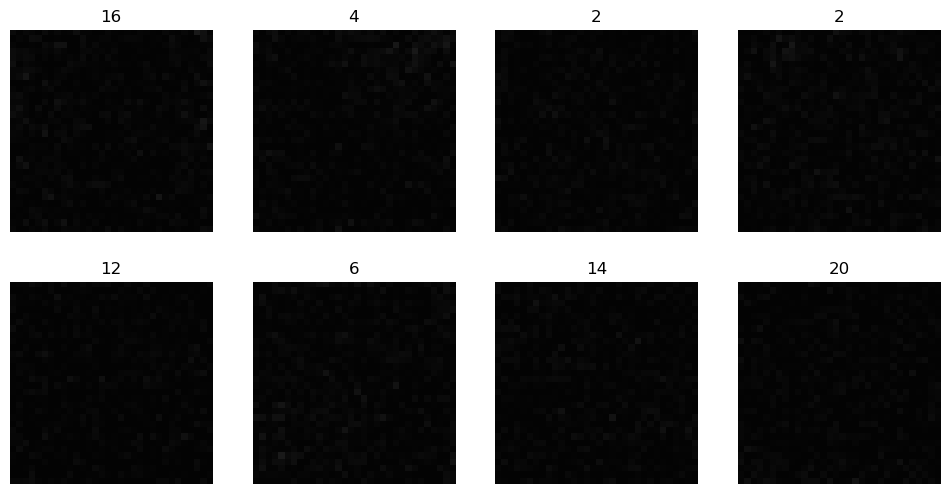

In [5]:
# dblock = DataBlock(blocks=(ImageBlock(cls=PILImageBW), ImageBlock(cls=PILImageBW)),
#                    get_items=get_image_files,
#                    get_y=get_noisy_pair,
#                    splitter=RandomSplitter(valid_pct=0.2),
#                    item_tfms=RandomCrop(64),
#                    )

dblock = DataBlock(blocks=(ImageBlock(), CategoryBlock()),
                    get_items=get_image_files,
                    get_y=parent_label,
                    item_tfms=RandomCrop(32),
                    )

# dblock.summary(path_train_raw)
# dsets = dblock.datasets(path_train_raw)
# dsets.train[0]
dls = dblock.dataloaders(path_train_raw)
dls.show_batch(max_n=8, cmap='gray')

In [6]:
# torch.mean(dls.one_batch()[0])

In [7]:
# dblock.summary(path_train_raw)

In [8]:
 #| export

import normflows as nf
# from Noise2Model.utils import attributesFromDict

# Import required packages
# import torchvision as tv
from matplotlib import pyplot as plt
from tqdm import tqdm

In [9]:
# Set up model

# Define flows
L = 3
K = 16
torch.manual_seed(0)

input_shape = (1, 64, 64)
n_dims = np.prod(input_shape)
channels = 1
hidden_channels = 256
split_mode = 'channel'
scale = True
num_classes = 20

# Set up flows, distributions and merge operations
q0 = []
merges = []
flows = []
for i in range(L):
    flows_ = []
    for j in range(K):
        flows_ += [nf.flows.GlowBlock(channels * 2 ** (L + 1 - i), hidden_channels,
                                     split_mode=split_mode, scale=scale)]
    flows_ += [nf.flows.Squeeze()]
    flows += [flows_]
    if i > 0:
        merges += [nf.flows.Merge()]
        latent_shape = (input_shape[0] * 2 ** (L - i), input_shape[1] // 2 ** (L - i), 
                        input_shape[2] // 2 ** (L - i))
    else:
        latent_shape = (input_shape[0] * 2 ** (L + 1), input_shape[1] // 2 ** L, 
                        input_shape[2] // 2 ** L)
    q0 += [nf.distributions.ClassCondDiagGaussian(latent_shape, num_classes)]


# Construct flow model with the multiscale architecture
model = nf.MultiscaleFlow(q0, flows, merges)

/home/biagio/miniconda3/envs/n2m/lib/python3.11/site-packages/torch/_tensor.py:738: UserWarning: torch.lu is deprecated in favor of torch.linalg.lu_factor / torch.linalg.lu_factor_ex and will be removed in a future PyTorch release.
LU, pivots = torch.lu(A, compute_pivots)
should be replaced with
LU, pivots = torch.linalg.lu_factor(A, compute_pivots)
and
LU, pivots, info = torch.lu(A, compute_pivots, get_infos=True)
should be replaced with
LU, pivots, info = torch.linalg.lu_factor_ex(A, compute_pivots) (Triggered internally at /opt/conda/conda-bld/pytorch_1699449183005/work/aten/src/ATen/native/BatchLinearAlgebra.cpp:1992.)
  LU, pivots, infos = torch._lu_with_info(


In [10]:
# Move model on GPU if available
enable_cuda = True
device = torch.device('cuda' if torch.cuda.is_available() and enable_cuda else 'cpu')
model = model.to(device)

# Train


In [11]:
# Train model
max_iter = 2

loss_hist = np.array([])

optimizer = torch.optim.Adamax(model.parameters(), lr=1e-3, weight_decay=1e-5)

for i in tqdm(range(max_iter)):
    try:
        x, y = next(train_iter)
    except:
        train_iter = iter(dls.train)
        x, y = next(train_iter)
    optimizer.zero_grad()
    loss = model.forward_kld(x.to(device), y.to(device))
        
    if ~(torch.isnan(loss) | torch.isinf(loss)):
        loss.backward()
        optimizer.step()

    loss_hist = np.append(loss_hist, loss.detach().to('cpu').numpy())

  0%|          | 0/2 [00:01<?, ?it/s]


RuntimeError: Given groups=1, weight of size [4, 4, 1, 1], expected input[64, 12, 16, 16] to have 4 channels, but got 12 channels instead

In [ ]:
plt.figure(figsize=(5, 5))
plt.plot(loss_hist, label='loss')
plt.legend()
plt.show()

## Evaluation


In [ ]:
# Model samples
num_sample = 10

with torch.no_grad():
    y = torch.arange(num_classes).repeat(num_sample).to(device)
    x, _ = model.sample(y=y)
    x_ = torch.clamp(x, 0, 1)
    plt.figure(figsize=(10, 10))
    plt.imshow(np.transpose(tv.utils.make_grid(x_, nrow=num_classes).cpu().numpy(), (1, 2, 0)))
    plt.show()

In [ ]:
# | hide
import nbdev
nbdev.nbdev_export()